# 

## Example of solar wind discontinuity

> from ARTEMIS observations with showing main parameters (theta, phi, omega) and their variations across the discontinuity

In [0]:
using Speasy
spz = speasy()

using DimensionalData
using DimensionalData: dims
using CairoMakie
using Statistics
using LinearAlgebra
using Unitful

tspan = ["2019-01-06T19:55:20", "2019-01-06T19:55:29"]
tspan = ["2021-04-03T04:57:40", "2021-04-03T04:57:55"]
spz_var = get_data("cda/THC_L2_FGM/thc_fgl_gsm", tspan)

In [0]:
using LaTeXStrings, Latexify, UnitfulLatexify
using Beforerr
using AlgebraOfGraphics

pub_theme = Beforerr.theme_pub(;)
aog_theme = Theme(AlgebraOfGraphics.aog_theme())
theme = merge(aog_theme, pub_theme)

with_theme(theme) do
    B_ts = DimArray(spz_var) * unit(spz_var)
    B_mva_ts = mva(B_ts, B_ts)

    Bn = B_mva_ts[:, 3]
    B0 = tnorm(B_mva_ts)

    θ = acos.(Bn ./ B0)
    φ = atan.(B_mva_ts[:, 1] ./ B_mva_ts[:, 2])

    B_mva_ts = rebuild(B_mva_ts; name="B")
    θ = rebuild(θ; name=:θ)
    φ = rebuild(φ; name=:φ)
    B_mva_ts, φ, θ = timeshift.([B_mva_ts, φ, θ])
    fa = tplot([B_mva_ts, [φ, θ]]; legend=(; labelsize=18))

    hvline = (; color=(:red, 0.5), linestyle=:dash, linewidth=1.5)
    hlines!([pi / 2]; hvline...)
    vlines!.(fa.axes, Ref([3.2, 11]); hvline...)

    B0_avg = mean(B0)
    θ_avg = mean(θ)
    ω_in = φ[end] - φ[1]
    title = latexify(:B_0 => B0_avg, :θ => θ_avg, :"ω_in=2β" => ω_in)
    Label(fa.figure[1, 1, Top()], title, fontsize=18)
    easy_save("../figures/example/thc")
end

## Schematic diagram of particle motion in a representative magnetic field profile

A diagram illustrating a representative magnetic field profile and representative particle trajectories in the test particle simulations, along with the key parameters used in the model.

In [0]:
using CurrentSheetTestParticle

begin
    θ = 85
    v = 8
    β = 75
    w = -0.9
    ϕ = (2.85, 2.87, 2.89)
    init_kwargs = (; w, ϕ)
    d = (; θ, β, v, init_kwargs)
    diffeq = (; dtmax=1e-3, CurrentSheetTestParticle.DEFAULT_DIFFEQ_KWARGS...)
    sols, (wϕs, B) = solve_params(RDProblemParams(; diffeq, d...))
end;

In [0]:
using Beforerr
using CurrentSheetTestParticle: field_lines
using LinearAlgebra

using CairoMakie
using GLMakie
using AlgebraOfGraphics

set_aog_theme!()
CairoMakie.activate!()

idxs = (1, 2, 3)
# Plot trajectories with guiding centers and field lines.
fig = Figure()

ax = Axis3(fig[1, 1], aspect=:data)

sol = sols[1]
start_point_coords = sol.u[1][1:3] # Get x,y,z of the first point
scatter!(ax, Point3f(start_point_coords); marker=:star5, markersize=15, color=Makie.wong_colors()[end-1]) # Plot the star

traj_label(i, μ0, μ1, ϕ0) = "T$(i): ϕ₀=$(round(ϕ0, digits=1))°, cos(α₁)=$(round(μ1, digits=1))"
@views for (sol, (w0, ϕ0_rad), i) in zip(sols, wϕs, 1:length(sols))
    ϕ0_deg = rad2deg(ϕ0_rad)
    μ1 = CurrentSheetTestParticle.cos_pitch_angle(sol.u[end], B)
    label = traj_label(i, w0, μ1, ϕ0_deg)
    lines!(ax, sol[1, :], sol[2, :], sol[3, :]; label=label)
end

axislegend(L"\text{Trajectories: } v_p = %$(v) v_B\ ,\ \cos(α_0)=%$(w)", position=(0.05, 0.8))

sol = sols[end]
fl0_sol, fl1_sol = field_lines(sol, B; dtmax=1)
fl0 = lines!(fl0_sol; idxs, color=:black)
fl1 = lines!(fl1_sol; idxs, color=:gray)

axislegend(ax, [fl0, fl1], ["Initial", "Final (ϕ₀=$(round(rad2deg(ϕ[end]), digits=1))°)"], L"\text{Field Lines: } θ = %$(θ)^∘,\ β = %$(β)^∘", position=(0.9, 0.8))

xlims!(ax, -290, 50)
ylims!(ax, -120, 130)
# easy_save("fig-B_diagram")

<figure>
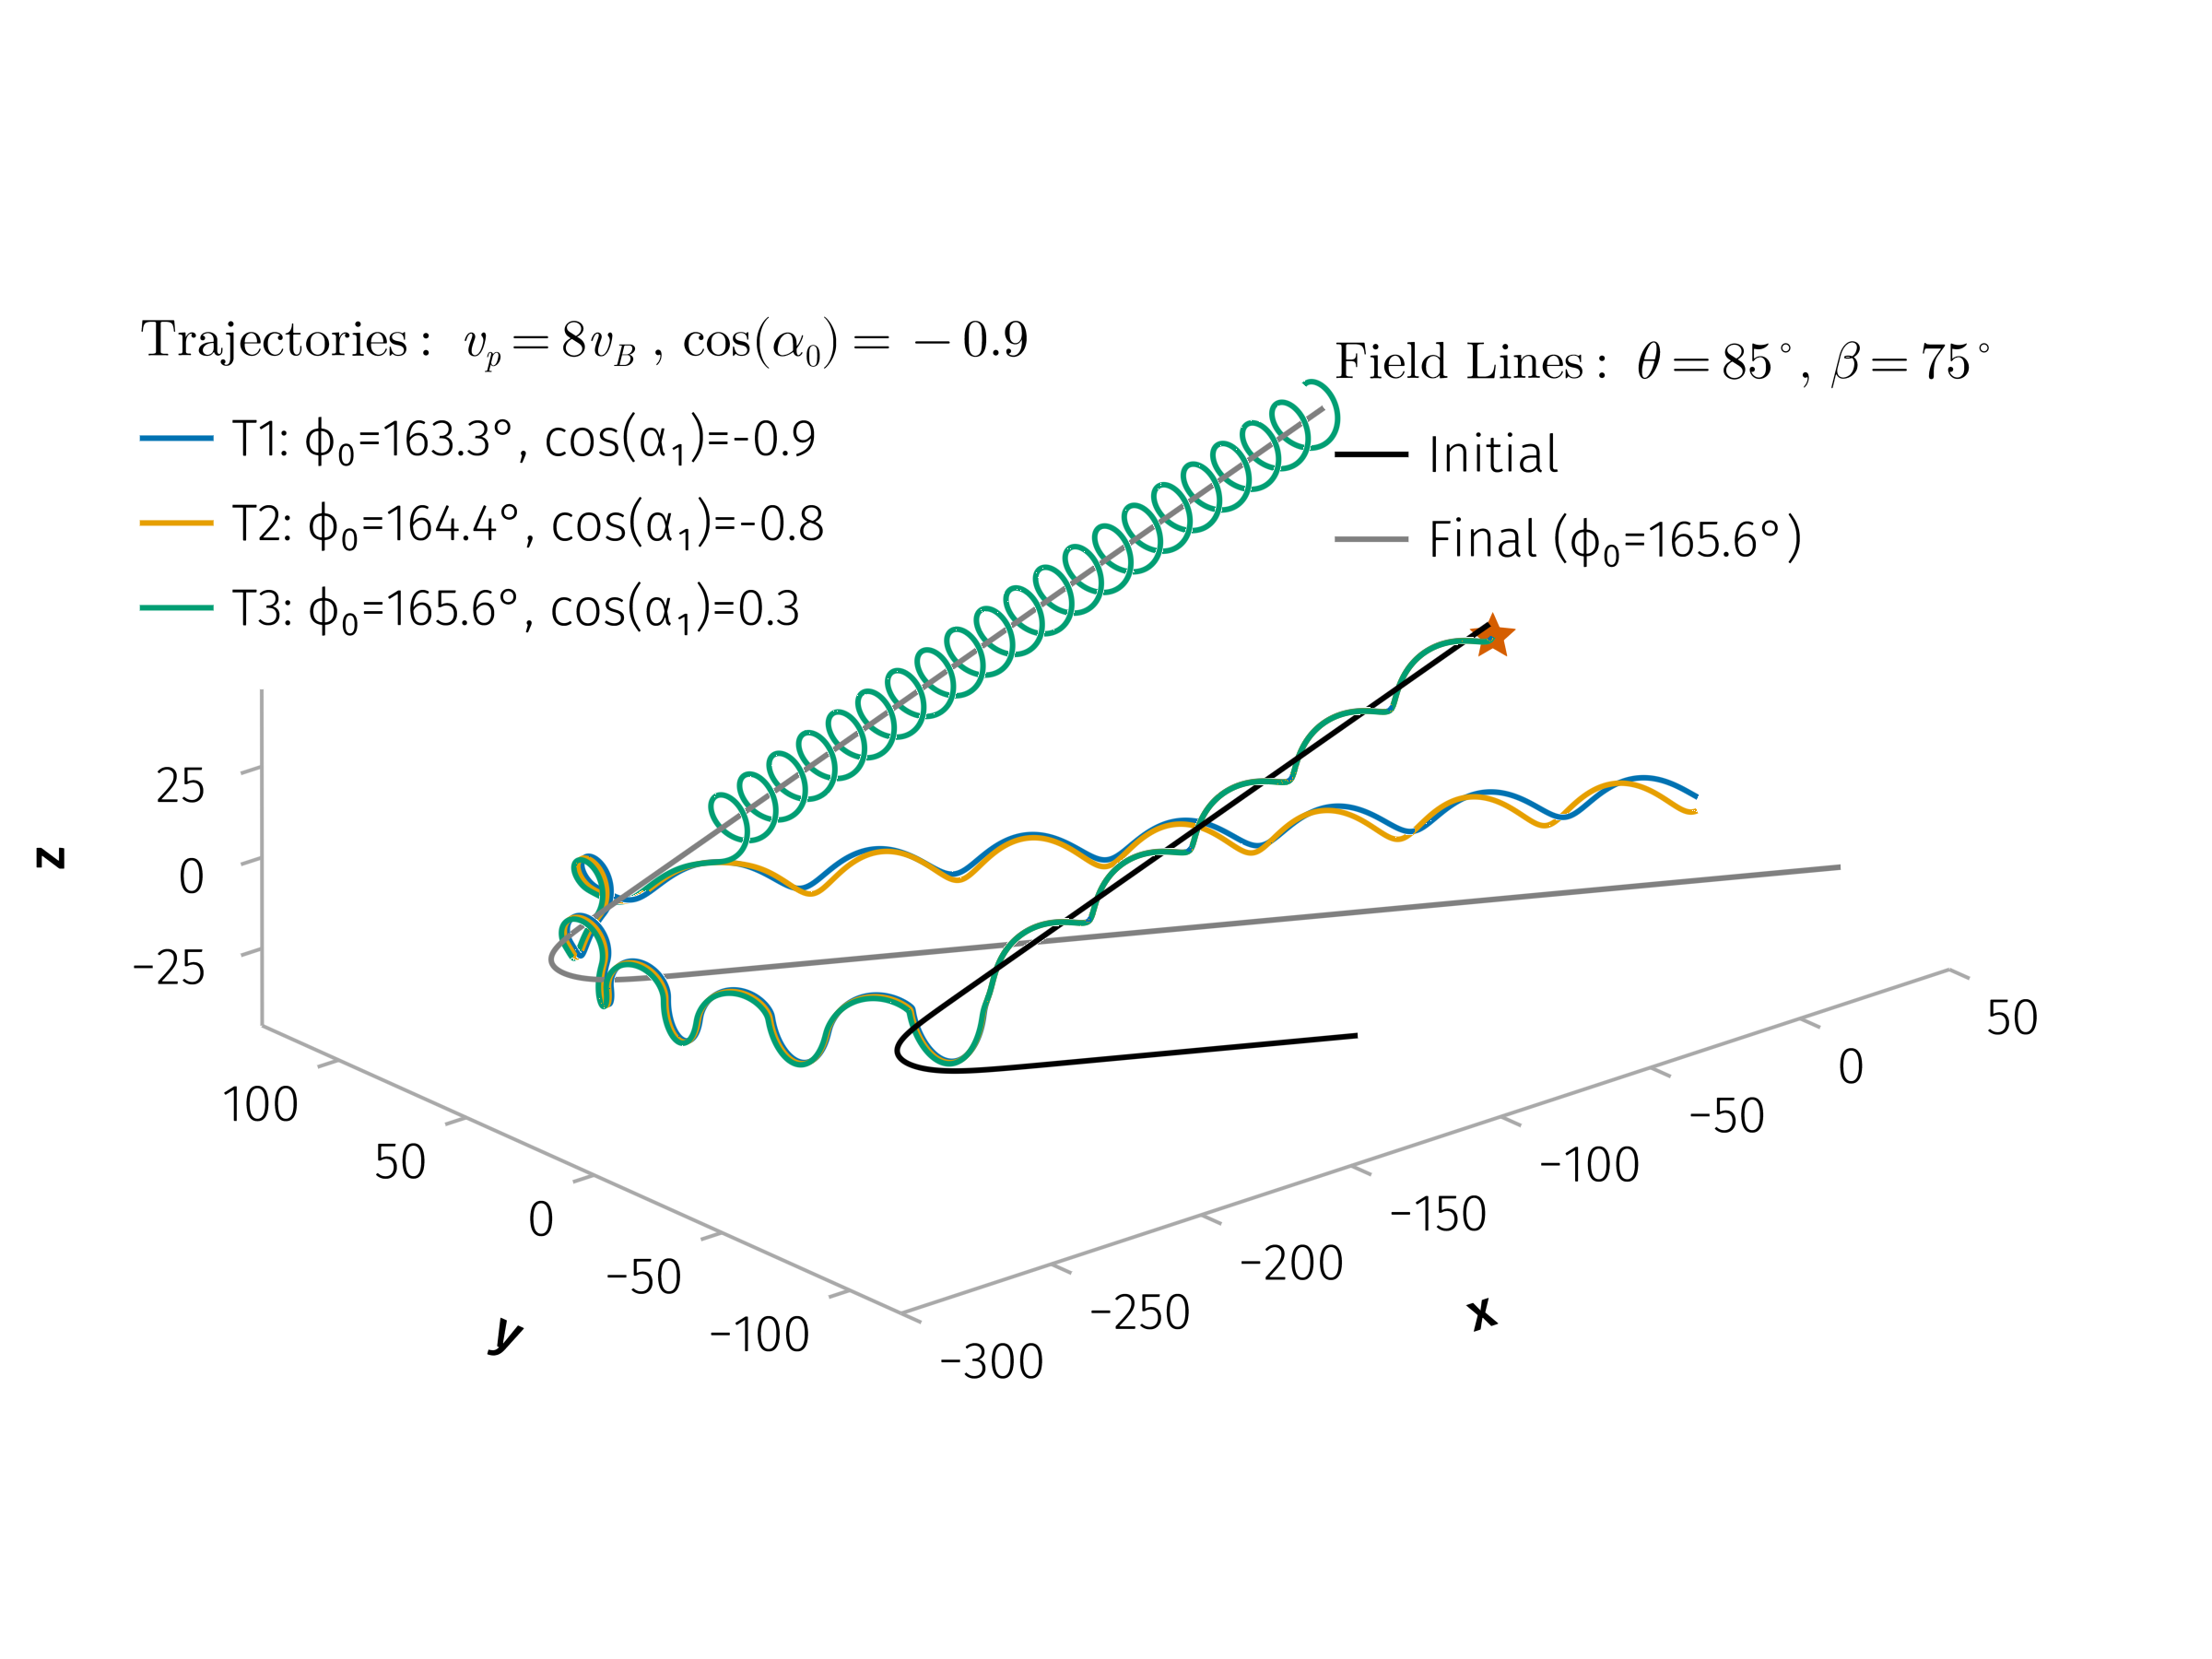
<figcaption>fig-B_diagram</figcaption>
</figure>